In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.preprocessing import Imputer
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt
from numpy import ma
from matplotlib import colors, ticker, cm
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm

In [2]:
'''Selecting amount of frames per utterance'''

df = pd.read_csv('audio_excel_script/archiefPraat.csv', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,claartje_corr_10.wav,145.76187009353646,144.63515155009998,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,178.18871400347038,176.18088186066825,...,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,0.876009,186.189865
1,claartje_corr_11.wav,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,...,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,1.236009,170.456585
2,claartje_corr_12.wav,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,164.6024288322113,160.43114736116414,156.17943589018262,155.18199882463426,...,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,1.500000,163.523779
3,claartje_corr_14.wav,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,...,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,1.220000,177.042752
4,claartje_corr_16.wav,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,...,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,--undefined--,0.948005,182.608955


In [3]:
def make_y_classes(fname):
    '''Takes in filename as input, returns
    the class it belongs to extracted from the
    filename.'''
    if "corr" in fname:
        return "COR"
    if "norm" in fname:
        return "NORM"

# use name to determine y class (correction or normal new information)
df.iloc[:,0] = df.iloc[:,0].apply(make_y_classes)

# with 251 features
X = np.array(df.loc[:, 1:249])
mean = np.array(df.loc[:, 251])
duration = np.array(df.loc[:, 250])

# Duration as exta feature
#X = np.hstack((X,duration))

# Take column group (column 0) as Y
Y = np.array(df.loc[:,0])

# 
def normalize(X):
    '''Normalize: haal means van waarden
    af en zet rest op 0 of andere waarde'''
    for row_index, row in enumerate(X):
        for column_index, col in enumerate(row):
            if col == '--undefined--':
                # Voorbeelden van waarden om '--undefined--' in te veranderen:
                # -float(200), -float(mean[row_index]), float(0), float(200)
                X[row_index][column_index] = - float(mean[row_index])
            else:
                X[row_index][column_index] = float(col) - float(mean[row_index])
    return X

normalize(X)

array([[-40.427994990552236, -41.55471353398872, -186.1898650840887, ...,
        -186.1898650840887, -186.1898650840887, -186.1898650840887],
       [-170.45658493052963, -170.45658493052963, -170.45658493052963,
        ..., -170.45658493052963, -170.45658493052963,
        -170.45658493052963],
       [-163.52377887177968, -163.52377887177968, -163.52377887177968,
        ..., -163.52377887177968, -163.52377887177968,
        -163.52377887177968],
       ...,
       [-245.7717944768779, -245.7717944768779, -245.7717944768779, ...,
        -245.7717944768779, -245.7717944768779, -245.7717944768779],
       [-256.7854037166277, -256.7854037166277, -256.7854037166277, ...,
        -256.7854037166277, -256.7854037166277, -256.7854037166277],
       [-243.51148344320214, -243.51148344320214, -243.51148344320214,
        ..., -243.51148344320214, -243.51148344320214,
        -243.51148344320214]], dtype=object)

In [4]:
def calc_score(predict, result):
    '''Takes prediction and y (result) as input
    and calculates accuracy'''
    truefalse = predict == result
    correct = np.sum(truefalse)
    return (correct/len(truefalse) * 100)

kf = KFold(n_splits=5, random_state=5, shuffle=True)

In [ ]:
def perform_svm(kf, g, Cee, X, Y):
    '''Carries out svm'''
    clf = svm.SVC(decision_function_shape="ovo", gamma=g, C=Cee)
    results = []
    best_result = (0, None, None, None)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        clf.decision_function_shape = "ovr"
        Y_predict = clf.predict(X_test)
        result = calc_score(Y_predict, Y_test)
        results.append(result)
        if result > best_result[0]:
            best_result = (result, clf, X_test, Y_predict)
    return (sum(results)/len(results), g, Cee, best_result)

gamvals = [i/10**exp for exp in range(1,12) for i in range(1,5)]
cvals = [i for i in range(1, 30)]

retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(perform_svm)(kf, g, Cee, X, Y) for g in gamvals for Cee in cvals)
best , bestgam, bestC, best_result = sorted(retLst, key=lambda tup: tup[0])[-1]

print('Accuracy: ', best)
print('Gamma: ', bestgam)
print('C: ', bestC)

In [30]:
import pickle

best_acc, best_model, best_X_test, best_Y_predict = best_result
pickle.dump(best_model, open("svm_best_model.p", "wb"))

In [31]:
# test if pickle works
best_model_2 = pickle.load(open("svm_best_model.p", "rb" ))
prediction = best_model_2.predict(best_X_test)
if best_Y_predict.all() == prediction.all():
    print("YES")

YES


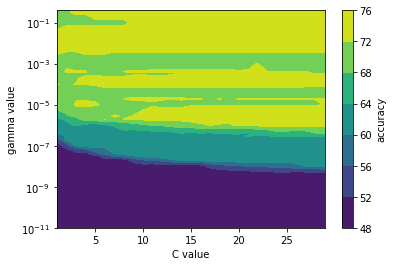

In [37]:
def perform_plot(data):
    '''Make surface plot of parameters c and gamma'''
    dff = pd.DataFrame(data, columns=['z','x','y'])
    dff = dff.pivot_table(values='z', index='x', columns='y')

    fig, ax = plt.subplots()
    cs = ax.contourf(dff.columns, dff.index,  dff)
    ax.set_yscale("log")
    ax.set_xlabel('C value')
    ax.set_ylabel('gamma value')

    cbar = fig.colorbar(cs, label='accuracy')
    plt.savefig('test', dpi=300)
    plt.show()
    
perform_plot(retLst)

In [38]:
def perform_pred_svm(kf, g, Cee, X, Y):
    '''Carries out svm, saves prediction'''
    clf = svm.SVC(decision_function_shape="ovo", gamma=g, C=Cee)
    best = 0
    predres = []
    valres = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf.fit(X_train, Y_train)
        clf.decision_function_shape = "ovr"
        Y_predict = clf.predict(X_test)
        score = calc_score(Y_predict, Y_test)
        if score > best:
            best = score
            predres = Y_predict
            valres = Y_test
        
        
    return (predres, valres)

results = {}
pred, val = perform_pred_svm(kf, 1e-06, 4, X, Y)


preds = pd.DataFrame(0, 
                 index=['COR', 'NORM'], 
                 columns=['COR', 'NORM'])


# ROWS zijn wat de pred zegt
# COLUMNS zijn wat het moet zijn
for i in range(len(pred)):
    preds.loc[pred[i], val[i]] += 1
preds

,COR,NORM
COR,23,7
NORM,11,21
